# 🩺 Heart Disease Prediction Model – Documentation
📌 Project Overview
This machine learning project aims to predict the presence of heart disease in patients based on various health indicators. The dataset used is heart.csv, containing both numerical and categorical features related to cardiovascular health.

📁 Dataset Description
🎯 Target Variable:
HeartDisease: Binary label indicating the presence (1) or absence (0) of heart disease.

## 🔢 Feature Categories:
Numerical (Skewed):

1.)Oldpeak

2.)FastingBS

Numerical (Normal):

e.g., Age, Cholesterol, etc. (excluding the skewed columns and target)

Categorical:

Columns of object data type, e.g., Sex, ChestPainType, etc.

## 📊 Exploratory Data Analysis (EDA)
Missing values were inspected (none present).

Distributions of numerical features were plotted using KDE plots, separated by heart disease status.

Categorical features were explored using histograms.

A joint KDE plot was used to visualize the interaction between Age and Cholesterol.

In [ ]:

#Importing necessary libraries
import pandas as pd
import numpy as np
import  matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier

In [87]:
#Loading the data from the csv file 
df = pd.read_csv('heart.csv')
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [88]:
# Performing EDA on the data
df.isnull().sum
df.describe()
heart = df.copy()

# Creating numeric and categoric columns 
num_col_skew = ["Oldpeak", "FastingBS"]
num_col_transform = [col for col in df.select_dtypes(include='number').columns if col not in ["Oldpeak", "FastingBS", "HeartDisease"] ]
num_col = [col for col in df.select_dtypes(include='number').columns if col!="HeartDisease"]
cat_features = df.select_dtypes(include='object').columns

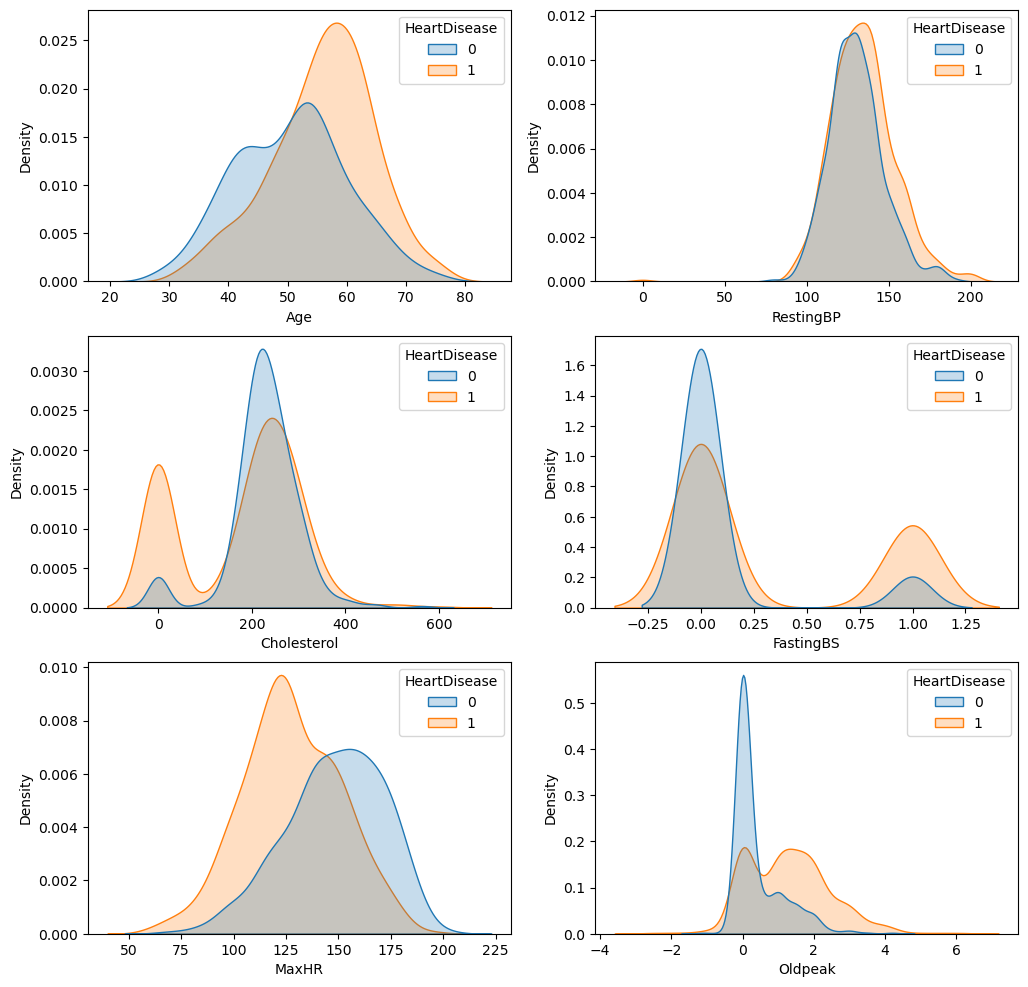

In [89]:
#Plotting distributions of numerical columns
plt.figure(figsize=(12, 12))
for i in range(6):
    plt.subplot(3, 2, (i+1))
    sns.kdeplot(x=num_col[i], data=df, fill=True, hue="HeartDisease")

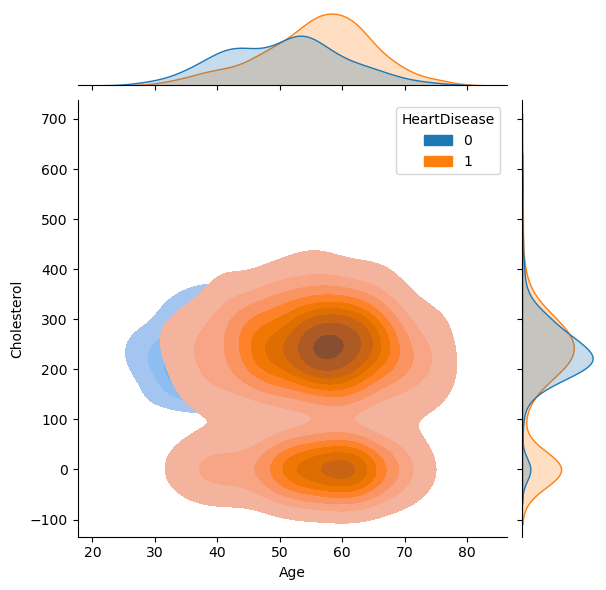

In [90]:
# Plotting a contour plot to understand the density of age and cholestrol 
sns.jointplot(data = df, x= 'Age', y = 'Cholesterol', kind='kde',  fill=True, hue='HeartDisease')

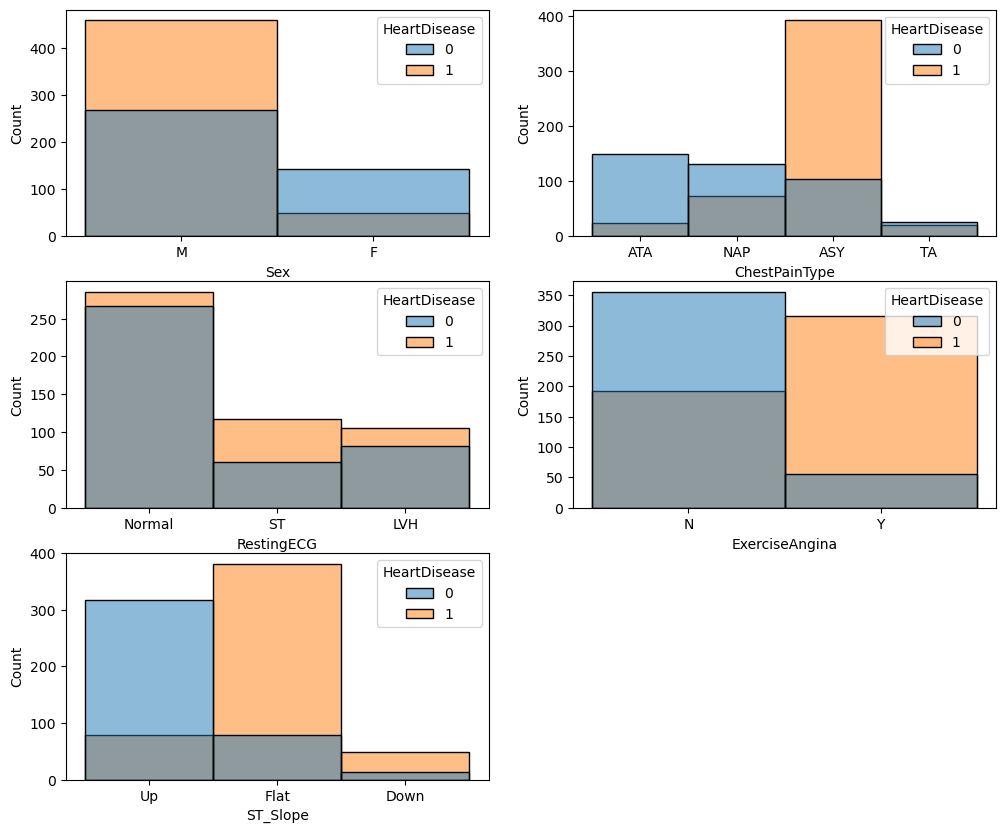

In [91]:
# Understanding categorical features
plt.figure(figsize=(12, 10))
for i in range(len(cat_features)):
    plt.subplot(3, 2, (i+1))
    sns.histplot(x=cat_features[i], data=df, hue="HeartDisease")

# 🛠️ Preprocessing Pipeline
A custom pipeline is defined using scikit-learn’s Pipeline and ColumnTransformer:

## 🔧 Pipeline Components:
1.)Numerical (Normal): Standard scaling using StandardScaler.

2.)Numerical (Skewed): Transformation using PowerTransformer (Yeo-Johnson method).

3.)Categorical: Encoding using OneHotEncoder.

In [92]:
# Creating pipelines
def create_pipeline():
    # Pipeline to scale numeric columns
    num_pip = Pipeline([
        ("scale", StandardScaler())
    ])

    num_skew = Pipeline([
        ("skew", PowerTransformer(method='yeo-johnson', standardize=True))
    ])
    
    # Pipeline to encode catgorical features
    cat_pip = Pipeline([
        ('ohe', OneHotEncoder())
    ])

    # Full pipeline consisting all ther pipelines  
    full_pip = ColumnTransformer([
        ("num", num_pip, num_col_transform),
        ("skew", num_skew, num_col_skew),
        ("cat", cat_pip, cat_features)         
    ])
    return full_pip


# 📉 Outlier Handling
Outliers in the training data were removed using IQR (Interquartile Range) method for selected features, as data was not normally distributed

In [93]:
#Creating Age Categories
df["Age_cat"] = pd.cut(df["Age"], bins=[10, 25, 40, 55, 70, np.inf], labels=[1, 2, 3 ,4, 5])
    

# Creating Traning and test data using Stratified Shuffle split
ss_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in ss_split.split(df, df["Age_cat"]):
    train_df = df.loc[train_index].drop("Age_cat", axis=1)
    test_df = df.loc[test_index].drop("Age_cat", axis=1)

# Removing outliers using IQR as all features are not normally distributed
def limits(feature):
    Q1 = train_df[feature].quantile(0.25)
    Q3 = train_df[feature].quantile(0.75)
    IQR = Q3 - Q1
    Lower = Q1 - 2.1 * IQR
    Upper = Q3 + 2.1* IQR
    return [Lower, Upper]

#Upper and lower limit for cholesterol values in the data after removing outliers
l1_cholestrol , u1_cholestrol = limits("Cholesterol")[0], limits("Cholesterol")[1]

#Upper and lower limit for Restingbp values in the data after removing outliers
l2_resting_bp , u2_restingbp = limits("RestingBP")[0], limits("RestingBP")[1]

train_df = train_df.query("@l1_cholestrol< Cholesterol < @u1_cholestrol and @l2_resting_bp<RestingBP< @u2_restingbp")

heart_df = train_df.copy()
target = heart_df["HeartDisease"]
heart_df = heart_df.drop("HeartDisease", axis=1)


# 🧠 Models Used
Several classification models were trained using a Bagging ensemble approach:

1.)LogisticRegression

2.)DecisionTreeClassifier

3.)RandomForestClassifier

4.)BaggingClassifier

In [95]:
# Dictionary of models 
models = {"ramdomforest":RandomForestClassifier(bootstrap= True,
 criterion='entropy',
 max_features= 'sqrt',
 min_samples_split= 4,
 n_estimators= 150,
 oob_score= False),
         "Logistic regressor":LogisticRegression(),
         "Descison Tree": DecisionTreeClassifier()
}

#Bagging the models for better prediction and avoiding overfitting of data
for model in models:
    clf = BaggingClassifier(estimator=models.get(model, 0),
                            n_estimators=10, random_state=0)
    
#CalculatingcCross Validation score for testing the performance of  models
    score = cross_val_score(
        clf,
        heart_processed,
        target,
        cv=10
        
    )
    print(f"Accuracy of {model} is :: {score.mean()*100}")


Accuracy of ramdomforest is :: 87.4048706240487
Accuracy of Logistic regressor is :: 85.74581430745815
Accuracy of Descison Tree is :: 84.36263318112634


In [94]:
# Transforming the Traning data set
heart_processed = create_pipeline().fit_transform(heart_df)

In [96]:
# Training a Random forest Classifier
model = RandomForestClassifier(bootstrap= True,
 criterion='entropy',
 max_features= 'sqrt',
 min_samples_split= 4,
 n_estimators= 150,
 oob_score= False)

#Fitting the model in the data
model.fit(heart_processed, target)

RandomForestClassifier(criterion='entropy', min_samples_split=4,
                       n_estimators=150)

In [97]:
#Preparing the test data 
test_data_target = test_df["HeartDisease"].copy()
test_df = test_df.drop("HeartDisease", axis=1)
output = test_df.copy()

#Transforming the test data
test_data_prepared = create_pipeline().fit_transform(test_df)

In [98]:
# Testing the accuracy of the model on test data-set
prediction = model.predict(test_data_prepared)
accuracy = accuracy_score(list(test_data_target), list(prediction))
accuracy

0.875

# ✅ Conclusion
1.)Pipeline successfully processes mixed data types and addresses skewness, scaling, and encoding.

2.)Cross-validation ensures reliable evaluation.

3.)RMSE serves as a robust metric given the regression-style prediction of a binary outcome (possibly for calibration).

In [99]:
#Storing the predicted values in a csv file
output["predicted"] = prediction
output.to_csv("predicted.csv", index=False)